# Project 2 - Starter Notebook

Please make sure your solution is divided into multiple code cells, explained clearly and properly, and most importantly, pretty.


In [0]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
import os,time
from pyspark.sql import SparkSession
 
spark = SparkSession.builder.appName("my_project_2").getOrCreate()

## Read Sub Demographic data

In [0]:
demographic_df = spark.read\
    .parquet("dbfs:/FileStore/project_b_data/proj_B_demographic/")
demographic_df.printSchema()
display(demographic_df.limit(10))

root
 |-- household_id: long (nullable = true)
 |-- household_size: integer (nullable = true)
 |-- num_adults: integer (nullable = true)
 |-- num_generations: integer (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- race_code: string (nullable = true)
 |-- dwelling_type: string (nullable = true)
 |-- home_owner_status: string (nullable = true)
 |-- length_residence: integer (nullable = true)
 |-- home_market_value: double (nullable = true)
 |-- net_worth: double (nullable = true)
 |-- gender_individual: string (nullable = true)
 |-- education_highest: string (nullable = true)



household_id,household_size,num_adults,num_generations,marital_status,race_code,dwelling_type,home_owner_status,length_residence,home_market_value,net_worth,gender_individual,education_highest
85,2,1,2,B,W,S,O,15,0.125,0.05,F,1
2073,1,1,2,M,H,S,O,15,0.15,0.1,F,1
2523,7,6,3,M,W,S,O,15,0.1,0.1,M,2
2717,3,2,2,S,W,S,O,11,0.125,0.2,M,3
3364,2,2,2,M,W,S,O,15,0.1,0.1,M,1
4046,4,3,3,M,W,S,O,6,0.075,0.05,F,1
4303,1,1,1,S,W,S,O,15,0.15,0.2,M,1
4559,3,2,2,S,W,S,O,12,0.175,0.2,F,2
5277,3,2,2,M,W,S,R,15,0.125,0.02,M,2
5440,1,1,1,S,W,S,O,8,0.225,0.2,F,1


## Read Static Viewing Data

In [0]:
schema = StructType([
    StructField("device_id", StringType(), True),
    StructField("event_date", StringType(), True),
    StructField("event_time", StringType(), True),     
    StructField("station_num", IntegerType(), True),
    StructField("prog_code", StringType(), True),
    StructField("household_id", IntegerType(), True)
])

viewing_static_df = spark.read.schema(schema)\
    .option("header", True).csv("dbfs:/FileStore/project_b_data/viewing_static_csv/")

viewing_static_df.printSchema()
display(viewing_static_df.limit(10))

root
 |-- device_id: string (nullable = true)
 |-- event_date: string (nullable = true)
 |-- event_time: string (nullable = true)
 |-- station_num: integer (nullable = true)
 |-- prog_code: string (nullable = true)
 |-- household_id: integer (nullable = true)



device_id,event_date,event_time,station_num,prog_code,household_id
001bd74cc8d1,20150120,181338,75523,EP000009110053,3783713
10ea5940d694,20150120,181338,11218,MV001054110000,3787015
44e08ed80c35,20150120,181338,11713,SH004464010000,43921
0000048de4f2,20150120,181338,65626,MV000506130000,3672067
0000059867a7,20150120,181338,58812,EP019199930005,3645541
000011ff9ba9,20150120,181338,18510,EP010855880111,3642303
00000254e5f6,20150120,181338,35513,EP000369550087,3825751
000002bd8a47,20150120,181338,10035,EP013413450102,2971023
000003c4c597,20150120,181338,59337,MV000744670000,2358722
00407bba00fe,20150120,181338,14771,EP015899250028,2838674


## Static Data Analysis (65 points)

In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler\
    , StringIndexer, OneHotEncoder, MinMaxScaler


### Feature Extraction

In [0]:

from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType, StringType, DoubleType

numerical_cols = ['household_size', 'num_adults', 'num_generations',\
     'length_residence', 'home_market_value', 'net_worth']
categorical_cols = ['marital_status', 'race_code', 'dwelling_type',\
     'home_owner_status', 'gender_individual', 'education_highest']

indexed_col = [c + "_index" for c in categorical_cols]
onehot_cols  = [c + "_onehot" for c in categorical_cols]

assembler_stage = VectorAssembler(inputCols=numerical_cols, \
    outputCol='num_features')
scaler_stage    = MinMaxScaler(inputCol='num_features', \
    outputCol='scaled_num_features')

# אינדוקס: skip כדי שלא יווצר דלי "invalid"
indexer = [StringIndexer(inputCol=c, outputCol=i, handleInvalid="skip")
           for c, i in zip(categorical_cols, indexed_col)]

# OHE: dropLast=True (ברירת מחדל) + error כדי לא להוסיף דלי נוסף
encoder = [OneHotEncoder(inputCol=i, outputCol=o, dropLast=True,\
     handleInvalid="error")
           for i, o in zip(indexed_col, onehot_cols)]

onehot_assembler = VectorAssembler(inputCols=onehot_cols,\
     outputCol='cat_features')
final_assembler  = VectorAssembler(inputCols=\
    ['scaled_num_features', 'cat_features'], outputCol='full_features')

stages = [assembler_stage, scaler_stage] + indexer +\
     encoder + [onehot_assembler, final_assembler]

pipeline = Pipeline(stages=stages)
model = pipeline.fit(demographic_df)
result_df = model.transform(demographic_df)

# הצג 7 שורות לפי הדרישה
display(result_df.select('household_id', 'full_features').limit(7))


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

🏃 View run efficient-panda-238 at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/30648897007770/runs/4c28426973a44a2d814551dddfc973a0
🧪 View experiment at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/30648897007770


household_id,full_features
85,"Map(vectorType -> sparse, length -> 18, indices -> List(0, 2, 3, 4, 5, 9, 12, 13, 15), values -> List(0.125, 0.5, 1.0, 0.12412412412412413, 0.05, 1.0, 1.0, 1.0, 1.0))"
2073,"Map(vectorType -> sparse, length -> 18, indices -> List(2, 3, 4, 5, 6, 11, 12, 13, 15), values -> List(0.5, 1.0, 0.14914914914914915, 0.1, 1.0, 1.0, 1.0, 1.0, 1.0))"
2523,"Map(vectorType -> dense, length -> 18, values -> List(0.75, 1.0, 1.0, 1.0, 0.09909909909909911, 0.1, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0))"
2717,"Map(vectorType -> dense, length -> 18, values -> List(0.25, 0.2, 0.5, 0.7333333333333333, 0.12412412412412413, 0.2, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0))"
3364,"Map(vectorType -> dense, length -> 18, values -> List(0.125, 0.2, 0.5, 1.0, 0.09909909909909911, 0.1, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0))"
4046,"Map(vectorType -> dense, length -> 18, values -> List(0.375, 0.4, 1.0, 0.4, 0.07407407407407408, 0.05, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0))"
4303,"Map(vectorType -> sparse, length -> 18, indices -> List(3, 4, 5, 7, 9, 12, 13, 14, 15), values -> List(1.0, 0.14914914914914915, 0.2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0))"


In [0]:
import pyspark.sql.functions as sfn
from pyspark.ml.functions import vector_to_array as v2a

# 1) Pull the vector safely (no 'col' alias anywhere)
dbg = (result_df
       .select("full_features")
       .withColumn("features_array", v2a(sfn.col("full_features"))))

# Show actual length and values for one row
row = dbg.select("features_array").limit(1).collect()[0]["features_array"]
print("Actual vector length:", len(row))
print("Vector values:", row)

# 2) Expected length (manual; no max, no risky aliases)
numerical_cols = [
    'household_size','num_adults','num_generations',
    'length_residence','home_market_value','net_worth'
]
categorical_cols = [
    'marital_status','race_code','dwelling_type',
    'home_owner_status','gender_individual','education_highest'
]

num_len = len(numerical_cols)

# distinct counts
dcnts = []
for name in categorical_cols:
    dcnts.append((name, demographic_df.select(name).distinct().count()))

# one-hot width = (count-1) if count>1 else 0
cat_len = 0
for _, d in dcnts:
    d_minus_1 = d - 1
    if d_minus_1 > 0:
        cat_len += d_minus_1

print("Distinct counts per categorical:", dcnts)
print("Expected numerical part:", num_len)
print("Expected categorical one-hot part:", cat_len)
print("Expected total vector length:", num_len + cat_len)


Actual vector length: 18
Vector values: [0.125, 0.0, 0.5, 1.0, 0.12412412412412413, 0.05, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0]
Distinct counts per categorical: [('marital_status', 4), ('race_code', 4), ('dwelling_type', 2), ('home_owner_status', 2), ('gender_individual', 2), ('education_highest', 4)]
Expected numerical part: 6
Expected categorical one-hot part: 12
Expected total vector length: 18


### Visual Analysis

In [0]:
from pyspark.ml.feature import PCA
from pyspark.ml.functions import vector_to_array 
from pyspark.sql import functions as F


🏃 View run secretive-bird-812 at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/30648897007770/runs/6cd0eab24f94476287cf5310320bdd57
🧪 View experiment at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/30648897007770


x,y
0.7696161667682888,-0.14328450444325935
1.0470607429479757,-0.8077002155153579
-0.21564461720437628,-1.6496380625532248
-0.1472713333051469,-0.009878108533882997
1.0866265581511159,-1.0202633541472845
0.9640643076197327,-0.9501483206226211
0.6852258565823554,0.33186218098408143


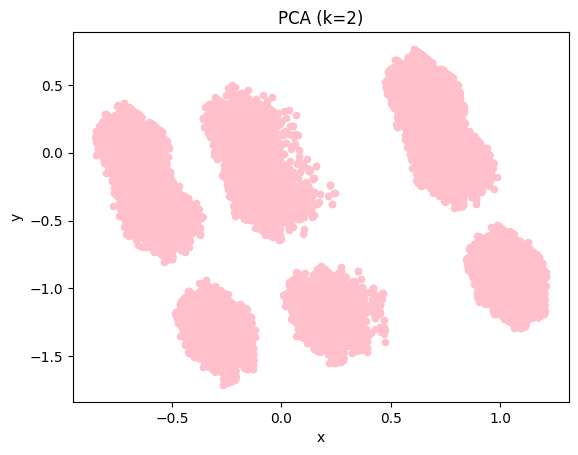

In [0]:
# PCA על וקטור הפיצ'רים
pca = PCA(k=2, inputCol="full_features", outputCol="pca_features")
pca_model = pca.fit(result_df)
pca_result = pca_model.transform(result_df)

# הוצאת x,y ממערך ה-PCA
pca_result = (pca_result
              .withColumn("pca_arr", vector_to_array(F.col("pca_features")))
              .withColumn("x", F.col("pca_arr")[0])
              .withColumn("y", F.col("pca_arr")[1])
              .select("x", "y"))

# הצגת 7 שורות כפי שדרשו
display(pca_result.limit(7))

# (אופציונלי) סקאטר בפנדהס
pdf = pca_result.select("x","y").toPandas()
ax = pdf.plot(kind="scatter", x="x", y="y", color="pink", title="PCA (k=2)")

### Clustering

In [0]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors
from pyspark.ml.linalg import VectorUDT
from pyspark.sql.types import StructType, StructField, IntegerType

In [0]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.functions import vector_to_array
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, IntegerType

# Step 1: Rename the actual feature vector (full_features -> features)
result_data = result_df.withColumnRenamed("full_features", "features")

# Step 2: Train KMeans model (k=6, seed=3). Use predictionCol='cluster'
# 3 for clarity
km = KMeans(k=6, seed=3, featuresCol="features", predictionCol="cluster")
km_model = km.fit(result_data)
km_result = km_model.transform(result_data)  # adds 'cluster'

# Step 3: Convert cluster centers to Spark Vectors with schema
centers = [(i, Vectors.dense(vec)) for i, vec in enumerate(km_model\
    .clusterCenters())]
schema = StructType([
    StructField("cluster", IntegerType(), False),
    StructField("centroid", VectorUDT(), False)
])
center_df = spark.createDataFrame(centers, schema=schema)

# Step 4: Join cluster assignments with cluster centers (by 'cluster')
km_result = km_result.join(center_df, on="cluster", how="left")

# Step 5: Convert vectors to arrays for Spark SQL operations
km_result = (km_result
    .withColumn("features_array", vector_to_array(F.col("features")))
    .withColumn("centroid_array", vector_to_array(F.col("centroid"))))

# Step 6: Compute distance to centroid (Euclidean). 
km_result = (km_result
    .withColumn("distance_sq",
                F.expr("aggregate(zip_with(features_array, centroid_array\
                    , (x, y) -> pow(x - y, 2)), 0D, (acc, z) -> acc + z)"))
    .withColumn("distance_to_centroid", F.sqrt(F.col("distance_sq")))
    .drop("features_array", "centroid_array", "distance_sq"))

# Step 7: Preview
km_result.printSchema()
display(km_result.select("household_id", "cluster", "distance_to_centroid")\
    .limit(7))


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

🏃 View run luminous-donkey-969 at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/30648897007770/runs/a20a2bc15fb3454da564df95d8cc3796
🧪 View experiment at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/30648897007770
root
 |-- cluster: integer (nullable = false)
 |-- household_id: long (nullable = true)
 |-- household_size: integer (nullable = true)
 |-- num_adults: integer (nullable = true)
 |-- num_generations: integer (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- race_code: string (nullable = true)
 |-- dwelling_type: string (nullable = true)
 |-- home_owner_status: string (nullable = true)
 |-- length_residence: integer (nullable = true)
 |-- home_market_value: double (nullable = true)
 |-- net_worth: double (nullable = true)
 |-- gender_individual: string (nullable = true)
 |-- education_highest: string (nullable = true)
 |-- num_features: vector (nullable = true)
 |-- scaled_num_features: vector (nullable = true)
 |-- m

household_id,cluster,distance_to_centroid
85,1,0.9568649711438204
2073,2,0.8481485938466666
2523,0,1.3296410205779297
2717,1,1.4315091453110265
3364,5,0.58615854643112
4046,5,0.9358106506190059
4303,1,0.9705720982818974


### Dividing households into subsets

In [0]:
from pyspark.sql.functions import col, expr, row_number
from pyspark.sql.window import Window


In [0]:
windowspec = Window.partitionBy("cluster").orderBy("distance_to_centroid")
assigned = km_result.withColumn("rank", row_number().over(windowspec))
full_subsets = {}
thirds_subsets = {}
seventeenths_subsets = {}
for i in range(6):
    full_subsets[i] = assigned.filter(col("cluster") == i)
    thirds_subsets[i] = full_subsets[i].filter(col("rank") % 3 == 0)
    seventeenths_subsets[i] = full_subsets[i].filter(col("rank") % 17 == 0)
for i in range(6):
    thirds_subsets[i] = thirds_subsets[i].cache()
    
display(full_subsets[4].select("household_id", "cluster", \
    "distance_to_centroid", "rank").orderBy("household_id").limit(20))

display(thirds_subsets[0].select("household_id", "rank", \
    "distance_to_centroid").orderBy("rank").limit(20))

display(seventeenths_subsets[0].select("household_id", "rank"\
    , "distance_to_centroid").orderBy("rank").limit(20))


household_id,cluster,distance_to_centroid,rank
828,4,1.0431279601805084,324
907,4,1.2070723215901578,4118
1000,4,1.0497595374377215,433
1043,4,1.033987174114564,179
1124,4,1.0828574619897031,1000
1143,4,1.3656220515631412,6828
1365,4,1.1175355527246138,1743
1480,4,1.1583557895242602,2956
1531,4,1.1795273576703513,3483
1628,4,1.1303754450258676,2308


household_id,rank,distance_to_centroid
3514686,3,0.7044092313106604
23167,6,0.7044092313106604
19916,9,0.7051120446118223
2164280,12,0.7053905341282163
2725436,15,0.7057182024603863
2410867,18,0.7065123836932489
2330934,21,0.7067903214482653
1969118,24,0.7067903214482653
3945526,27,0.7072564951095969
3240541,30,0.7072564951095969


household_id,rank,distance_to_centroid
1942214,17,0.7058109647851379
1587557,34,0.7092062918941878
75562,51,0.7102731458187951
2156491,68,0.7126346736912084
3665179,85,0.7129129849888168
19624,102,0.7134667194446199
2208866,119,0.7139743002200348
3236947,136,0.7141606192279557
3031763,153,0.7148052168459772
2229286,170,0.7152644128448189


### Cluster’s Viewing Analysis

In [0]:
from pyspark.sql.functions import col, count, lit

# סופרים רק צפיות עם מספר תחנה תקין
all_count = viewing_static_df.where(col("station_num").\
  isNotNull()).count()

# שומרים על שם העמודה המקורי כדי לא לשבור קוד בהמשך
general_population = (
    viewing_static_df
      .where(col("station_num").isNotNull())
      .groupBy("station_num")
      .agg(count("*").alias("count"))
      .withColumn("genreal_precentage", (col("count") / \
        lit(all_count)) * 100)  # אחוזים
)

display(general_population.limit(20))
print(all_count)


station_num,count,genreal_precentage
11458,7864,0.108872122741966
11858,1777,0.02460144482610295
32414,644,0.00891577403939803
31035,2826,0.03912418856419074
11317,8777,0.12151203221086415
10817,196,0.002713496446773314
31236,863,0.011947690987578417
43714,497,0.0068806517043180455
59355,33,4.5686419767101706E-4
22223,6,8.306621775836674E-5


7223153


In [0]:
from pyspark.sql.functions import col, count

tmp = (
    viewing_static_df
      .where(col("station_num").isNotNull())  
      .groupBy("household_id")
      .agg(count("*").alias("count"))
      .select("household_id", "count")
      .orderBy("count", ascending=False)
)

tmp.show()


+------------+-----+
|household_id|count|
+------------+-----+
|     2724124| 3388|
|     3611285| 2570|
|     2509469| 2037|
|     2901019| 1845|
|     3617223| 1797|
|     2460935| 1745|
|      408868| 1709|
|     2663349| 1636|
|     2057408| 1624|
|     3616005| 1587|
|     2903914| 1578|
|     2904998| 1478|
|     2715652| 1471|
|     2257104| 1429|
|     1471911| 1421|
|      649170| 1407|
|       45491| 1405|
|     2691943| 1388|
|     3798503| 1381|
|      404684| 1286|
+------------+-----+
only showing top 20 rows



In [0]:
from pyspark.sql.functions import col, broadcast

viewing_full = {}
viewing_thirds = {}
viewing_seventeenths = {}
viewing_counts = {"full": [], "thirds": [], "seventeenths": []}

viewing_static_df.cache()

for i in range(6):
    print(f"\nCluster {i}:")
    full_ids = (
        broadcast(
            full_subsets[i]
              .filter(col("household_id").isNotNull())
              .select("household_id")
              .distinct()
              .alias("subset")
        )
    )

    thirds_ids = (
        broadcast(
            thirds_subsets[i]
              .filter(col("household_id").isNotNull())
              .select("household_id")
              .distinct()
              .alias("subset")
        )
    )

    seventeenths_ids = (
        broadcast(
            seventeenths_subsets[i]
              .filter(col("household_id").isNotNull())
              .select("household_id")
              .distinct()
              .alias("subset")
        )
    )

    # חשוב: סינון station_num תקין לפני ה-join
    viewing_full[i] = (
        viewing_static_df
          .where(col("station_num").isNotNull())
          .alias("viewing")
          .join(full_ids, col("viewing.household_id") ==\
               col("subset.household_id"))
    )
    view_full_count = viewing_full[i].count()
    print(f"  Full subset → {full_subsets[i].count()} households")
    print(f"  Viewing rows (Full) → {view_full_count}")
    display(viewing_full[i].select("viewing.household_id", \
        "viewing.station_num").limit(5))
    viewing_counts["full"].append(view_full_count)

    viewing_thirds[i] = (
        viewing_static_df
          .where(col("station_num").isNotNull())
          .alias("viewing")
          .join(thirds_ids, col("viewing.household_id") == \
              col("subset.household_id"))
    )
    view_thirds_count = viewing_thirds[i].count()
    print(f"  Thirds subset → {thirds_subsets[i].count()} households")
    print(f"  Viewing rows (Thirds) → {view_thirds_count}")
    display(viewing_thirds[i].select("viewing.household_id",\
         "viewing.station_num").limit(5))
    viewing_counts["thirds"].append(view_thirds_count)

    viewing_seventeenths[i] = (
        viewing_static_df
          .where(col("station_num").isNotNull())
          .alias("viewing")
          .join(seventeenths_ids, col("viewing.household_id") == col("subset.household_id"))
    )
    view_sevenths_count = viewing_seventeenths[i].count()
    print(f"  17ths subset → {seventeenths_subsets[i].count()} households")
    print(f"  Viewing rows (17ths) → {view_sevenths_count}")
    display(viewing_seventeenths[i].select("viewing.household_id",\
         "viewing.station_num").limit(5))
    viewing_counts["seventeenths"].append(view_sevenths_count)



Cluster 0:
  Full subset → 78987 households
  Viewing rows (Full) → 1565983


household_id,station_num
3642303,18510
2971023,10035
3760805,21250
49895,19326
2276833,32786


  Thirds subset → 26329 households
  Viewing rows (Thirds) → 526001


household_id,station_num
3642303,18510
3760805,21250
52858,19313
3224853,31042
2744790,64244


  17ths subset → 4646 households
  Viewing rows (17ths) → 96688


household_id,station_num
1518381,32645
2715978,80619
20635,14771
2424532,21883
2673747,32677



Cluster 1:
  Full subset → 87383 households
  Viewing rows (Full) → 1701257


household_id,station_num
3787015,11218
3645541,58812
3825751,35513
2838674,14771
2679446,16752


  Thirds subset → 29127 households
  Viewing rows (Thirds) → 559437


household_id,station_num
3787015,11218
3645541,58812
1605319,49788
2054439,60468
1489172,12574


  17ths subset → 5140 households
  Viewing rows (17ths) → 97810


household_id,station_num
2054439,60468
3821486,45507
2054439,59337
2670137,42642
2116032,10325



Cluster 2:
  Full subset → 16545 households
  Viewing rows (Full) → 283916


household_id,station_num
43921,11713
2101605,18480
2029846,10568
2428475,18480
43921,11713


  Thirds subset → 5515 households
  Viewing rows (Thirds) → 90185


household_id,station_num
43921,11713
43921,11713
3601868,16046
3124313,70387
3601868,44714


  17ths subset → 973 households
  Viewing rows (17ths) → 19048


household_id,station_num
1980937,10057
2852949,65732
2289579,70225
2974452,31658
1947982,60179



Cluster 3:
  Full subset → 22534 households
  Viewing rows (Full) → 507936


household_id,station_num
3850378,47540
2327767,10537
1980391,10458
3216462,23315
2348192,14815


  Thirds subset → 7511 households
  Viewing rows (Thirds) → 175179


household_id,station_num
3216462,23315
2348192,14815
3491582,12574
2148557,12729
2788047,10162


  17ths subset → 1325 households
  Viewing rows (17ths) → 31641


household_id,station_num
3016583,44940
3016583,10918
2136400,10145
2483168,11158
3016583,44940



Cluster 4:
  Full subset → 12389 households
  Viewing rows (Full) → 245972


household_id,station_num
3672067,65626
2966025,64065
3704832,11150
3460567,99995
2084973,64490


  Thirds subset → 4129 households
  Viewing rows (Thirds) → 81700


household_id,station_num
2084973,64490
2451093,10556
2187632,10142
1965232,35312
2182981,58515


  17ths subset → 728 households
  Viewing rows (17ths) → 13737


household_id,station_num
2182981,58515
3761306,10377
3158329,18480
3516159,18480
2715058,61522



Cluster 5:
  Full subset → 139883 households
  Viewing rows (Full) → 2918089


household_id,station_num
3783713,75523
2358722,59337
2965021,48999
91472,12574
1601677,11919


  Thirds subset → 46627 households
  Viewing rows (Thirds) → 979441


household_id,station_num
2041418,24824
2802843,12510
1593610,60179
2804129,34240
3069472,35885


  17ths subset → 8228 households
  Viewing rows (17ths) → 176402


household_id,station_num
3783713,75523
3625465,47540
118915,16485
2983237,14321
2724596,58780


In [0]:
from pyspark.sql.functions import col, count, lit

full_final = {}
thirds_final = {}
seventeenths_final = {}

for i in range(6):
    print(f"\n📊 Cluster {i} – Full subset station distribution:")
    full_final[i] = (
        viewing_full[i]
          .groupBy("station_num")
          .agg(count("*").alias("count"))
          .withColumn("sub_rat", (col("count") / \
            lit(viewing_counts["full"][i])) * 100)  # אחוזים
          .orderBy(col("sub_rat").desc())
    )
    display(full_final[i].limit(5))

    print(f"📊 Cluster {i} – Thirds subset station distribution:")
    thirds_final[i] = (
        viewing_thirds[i]
          .groupBy("station_num")
          .agg(count("*").alias("count"))
          .withColumn("sub_rat", (col("count") /\
             lit(viewing_counts["thirds"][i])) * 100)  # אחוזים
          .orderBy(col("sub_rat").desc())
    )
    display(thirds_final[i].limit(5))

    print(f"📊 Cluster {i} – 17ths subset station distribution:")
    seventeenths_final[i] = (
        viewing_seventeenths[i]
          .groupBy("station_num")
          .agg(count("*").alias("count"))
          .withColumn("sub_rat", (col("count") / \
            lit(viewing_counts["seventeenths"][i])) * 100)  # אחוזים
          .orderBy(col("sub_rat").desc())
    )
    display(seventeenths_final[i].limit(5))




📊 Cluster 0 – Full subset station distribution:


station_num,count,sub_rat
60179,28367,1.811450060441269
16374,27062,1.7281158224578426
32645,19927,1.2724914638281513
14771,18878,1.2055047851732745
49788,18391,1.174406107856854


📊 Cluster 0 – Thirds subset station distribution:


station_num,count,sub_rat
16374,9000,1.7110233630734544
60179,8922,1.6961944939268176
32645,7466,1.4193889365229344
14771,6236,1.1855490769028956
49788,5841,1.1104541626346718


📊 Cluster 0 – 17ths subset station distribution:


station_num,count,sub_rat
16374,2248,2.3250041370180377
10142,1191,1.231797120635446
14902,1189,1.2297286116167467
32645,1142,1.1811186496773125
60179,1080,1.1169948700976338



📊 Cluster 1 – Full subset station distribution:


station_num,count,sub_rat
16374,24039,1.413014024336123
60179,20754,1.2199215050988768
14771,20403,1.1992897016735273
32645,20301,1.1932941348661608
11207,19799,1.1637865413632391


📊 Cluster 1 – Thirds subset station distribution:


station_num,count,sub_rat
16374,7496,1.3399185252316168
32645,6866,1.2273053087300267
60179,6638,1.1865500494246894
14771,6428,1.149012310590826
11207,6207,1.1095083092466176


📊 Cluster 1 – 17ths subset station distribution:


station_num,count,sub_rat
16374,1487,1.5202944484204068
12131,1383,1.4139658521623557
32645,1338,1.3679582864737756
14902,1287,1.3158163786933852
60179,1274,1.3025253041611289



📊 Cluster 2 – Full subset station distribution:


station_num,count,sub_rat
12131,6203,2.1848011383648687
10171,4639,1.6339339804730977
11207,3105,1.0936333281674862
59684,3080,1.0848279068456868
14771,3035,1.0689781484664478


📊 Cluster 2 – Thirds subset station distribution:


station_num,count,sub_rat
12131,2409,2.6711759161723125
10171,1557,1.726451183677995
32645,929,1.030104784609414
11207,924,1.024560625381161
10021,916,1.0156899706159561


📊 Cluster 2 – 17ths subset station distribution:


station_num,count,sub_rat
10171,344,1.8059638807223857
12131,325,1.7062158756824863
59684,278,1.4594708105837884
11867,232,1.2179756404871904
58515,220,1.1549769004619908



📊 Cluster 3 – Full subset station distribution:


station_num,count,sub_rat
12131,9448,1.8600768600768602
10171,8755,1.7236423486423487
10179,8682,1.7092704592704595
11207,8456,1.6647766647766646
10918,8140,1.6025641025641024


📊 Cluster 3 – Thirds subset station distribution:


station_num,count,sub_rat
10179,3170,1.809577632022103
11207,2996,1.7102506578984922
12131,2945,1.6811375792760548
35513,2847,1.6251948007466648
10171,2668,1.5230136032286976


📊 Cluster 3 – 17ths subset station distribution:


station_num,count,sub_rat
10171,908,2.8696943838690308
10179,810,2.559969659618849
12131,625,1.9752852311873834
32645,523,1.6529186814576027
16615,454,1.4348471919345154



📊 Cluster 4 – Full subset station distribution:


station_num,count,sub_rat
12131,4691,1.9071276405444524
10171,3771,1.533101328606508
32645,3133,1.273722212284325
11207,2992,1.2163986144764445
10918,2952,1.2001366009139252


📊 Cluster 4 – Thirds subset station distribution:


station_num,count,sub_rat
12131,1478,1.8090575275397796
10171,1362,1.6670746634026927
11207,1242,1.5201958384332925
32645,1235,1.5116279069767442
10918,1010,1.2362301101591189


📊 Cluster 4 – 17ths subset station distribution:


station_num,count,sub_rat
10171,401,2.9191235349785254
12131,322,2.344034359758317
11207,211,1.53599767052486
11221,195,1.4195239135182356
10918,192,1.3976850840794932



📊 Cluster 5 – Full subset station distribution:


station_num,count,sub_rat
16374,48065,1.6471396177429816
60179,46390,1.5897390381170688
14771,37482,1.2844707615154987
32645,32706,1.1208020043254334
14902,32418,1.1109325315300527


📊 Cluster 5 – Thirds subset station distribution:


station_num,count,sub_rat
60179,15606,1.5933578439130076
16374,15356,1.5678330802978435
14771,12544,1.2807305391544768
11207,11073,1.130542830042851
14902,10911,1.1140027832202246


📊 Cluster 5 – 17ths subset station distribution:


station_num,count,sub_rat
16374,2726,1.545333953129783
60179,2338,1.3253817983923084
14771,2146,1.2165394950170634
11207,1941,1.1003276606841192
32645,1776,1.0067913062210179


In [0]:
from pyspark.sql.functions import col, coalesce

full_result = {}
thirds_result = {}
seventeenths_result = {}

for i in range(6):
    print(f"\n📊 Cluster {i} – Full subset:")
    full_result[i] = (
        full_final[i].alias("subset")
        .join(
            general_population.alias("general"),
            col("subset.station_num") == col("general.station_num"),
            how="full_outer"  # חשוב
        )
        .select(
            coalesce(col("subset.station_num"),\
                 col("general.station_num")).alias("station_num"),
            col("subset.sub_rat").alias("sub_rat"),
            col("general.genreal_precentage").alias("genreal_precentage")
        )
        .fillna({"sub_rat": 0.0, "genreal_precentage": 0.0})
        .withColumn("diff_rank", col("sub_rat") - col("genreal_precentage"))
        .select("station_num", "diff_rank")
        .orderBy(col("diff_rank").desc())
    )
    display(full_result[i].limit(7))  # לפי הדרישה - הטופ 7

    print(f"📊 Cluster {i} – Thirds subset:")
    thirds_result[i] = (
        thirds_final[i].alias("subset")
        .join(
            general_population.alias("general"),
            col("subset.station_num") == col("general.station_num"),
            how="full_outer"
        )
        .select(
            coalesce(col("subset.station_num"), \
                col("general.station_num")).alias("station_num"),
            col("subset.sub_rat").alias("sub_rat"),
            col("general.genreal_precentage").alias("genreal_precentage")
        )
        .fillna({"sub_rat": 0.0, "genreal_precentage": 0.0})
        .withColumn("diff_rank", col("sub_rat") - col("genreal_precentage"))
        .select("station_num", "diff_rank")
        .orderBy(col("diff_rank").desc())
    )
    display(thirds_result[i].limit(7))

    print(f"📊 Cluster {i} – 17ths subset:")
    seventeenths_result[i] = (
        seventeenths_final[i].alias("subset")
        .join(
            general_population.alias("general"),
            col("subset.station_num") == col("general.station_num"),
            how="full_outer"
        )
        .select(
            coalesce(col("subset.station_num"), \
                col("general.station_num")).alias("station_num"),
            col("subset.sub_rat").alias("sub_rat"),
            col("general.genreal_precentage").alias("genreal_precentage")
        )
        .fillna({"sub_rat": 0.0, "genreal_precentage": 0.0})
        .withColumn("diff_rank", col("sub_rat") - col("genreal_precentage"))
        .select("station_num", "diff_rank")
        .orderBy(col("diff_rank").desc())
    )
    display(seventeenths_result[i].limit(7))



📊 Cluster 0 – Full subset:


station_num,diff_rank
60179,0.3920006870166719
16374,0.22730308873892513
49788,0.2045526380494167
32645,0.1001779326043215
10335,0.08745533979025041
50747,0.08060981371936737
61854,0.07566834124361119


📊 Cluster 0 – Thirds subset:


station_num,diff_rank
16374,0.256218146450512
60179,0.22104180434882914
32645,0.1735014006869462
45507,0.1097926770565591
49788,0.10752090780781431
11865,0.09379017355144018
11069,0.0891289484237503


📊 Cluster 0 – 17ths subset:


station_num,diff_rank
16374,0.33292051135803113
35070,0.19492094633199625
11069,0.1932363748678282
49788,0.18334030811743451
61522,0.1804327586777299
59684,0.17904090797268046
30754,0.1670806972293202



📊 Cluster 1 – Full subset:


station_num,diff_rank
74796,0.09908511426226463
16615,0.07821507285923013
58515,0.0729052049584783
15433,0.06216254750469358
11867,0.05490510429148865
10145,0.05024015654787872
18151,0.045981363105474835


📊 Cluster 1 – Thirds subset:


station_num,diff_rank
74796,0.1392865993066058
16615,0.11075668989285414
11867,0.1096502217405041
35859,0.10889860721950724
15433,0.10125561152544815
10145,0.09221123263989317
58515,0.08846224323634289


📊 Cluster 1 – 17ths subset:


station_num,diff_rank
12574,0.42009922429903135
16374,0.36913921393469673
14902,0.32957228735556776
11158,0.2609606369274394
16615,0.2540155817987787
16123,0.2534212311635268
10057,0.25319885004926873



📊 Cluster 2 – Full subset:


station_num,diff_rank
12131,1.0873718024502066
11118,0.7932517659986893
10222,0.732710780236983
10171,0.6282651264421779
59684,0.49541771437156923
44714,0.3917355689600071
21883,0.3498073553587867


📊 Cluster 2 – Thirds subset:


station_num,diff_rank
12131,1.5737465802576505
10222,0.7723033249399333
11118,0.7675798303462545
10171,0.7207823296470752
21883,0.5843193660815698
17927,0.4054949480904666
10153,0.3403690111704121


📊 Cluster 2 – 17ths subset:


station_num,diff_rank
10222,0.8519435073760694
59684,0.7493130330613718
11118,0.6866909314085933
44714,0.5983916698508663
10171,0.5745495416011677
10239,0.545472181112538
14968,0.5122555590674094



📊 Cluster 3 – Full subset:


station_num,diff_rank
35513,1.240484333024132
70387,0.9286958286186878
11706,0.8767181790254264
10918,0.8436296040147847
10179,0.7654444043606439
12131,0.7626475241621982
10171,0.7179734946114289


📊 Cluster 3 – Thirds subset:


station_num,diff_rank
35513,1.3144994575911204
11706,0.9622786500344955
10179,0.8657515771122875
70387,0.7954536704334713
10918,0.7349660260569423
16615,0.6604763228512717
11164,0.6154874482562301


📊 Cluster 3 – 17ths subset:


station_num,diff_rank
10179,1.5940204101197344
10171,1.1307996520213544
11706,0.8654456506864336
35513,0.7701807353501917
10559,0.6934717557767988
12131,0.6850680567088328
11809,0.640488085647964



📊 Cluster 4 – Full subset:


station_num,diff_rank
12131,0.8096983046297903
10171,0.5274324745755883
70387,0.480288515812175
10918,0.44120210236460744
11706,0.3840230810500525
35513,0.38084678359058927
10642,0.36311743823346204


📊 Cluster 4 – Thirds subset:


station_num,diff_rank
12131,0.7116281916251175
10171,0.661405809371773
11809,0.5424399749916053
10642,0.523644730340886
11706,0.518470402784994
70387,0.49605184089514076
10918,0.47729561160980116


📊 Cluster 4 – 17ths subset:


station_num,diff_rank
10171,1.2073325290949448
12131,1.1665293159016008
35513,0.9850752035431527
10642,0.9316990260724951
10918,0.8061816112271983
14767,0.6493799613609541
70387,0.6182714108564235



📊 Cluster 5 – Full subset:


station_num,diff_rank
60179,0.17028966469247164
16374,0.14632688402406413
19606,0.10247038444002322
11713,0.09290124219643248
14771,0.08079973308788535
11661,0.0792271519320012
57708,0.06647335945716687


📊 Cluster 5 – Thirds subset:


station_num,diff_rank
60179,0.1739084704884104
19606,0.09859784122661984
11661,0.09046155511766307
11954,0.08788048485578892
30754,0.08519435587452426
14771,0.07705951072686346
11765,0.07349965224943972


📊 Cluster 5 – 17ths subset:


station_num,diff_rank
16374,0.28884951500842115
60179,0.2477652840055906
18544,0.14507241822226394
31258,0.13235024132470305
19630,0.13088946082804936
20290,0.11982721060094331
10139,0.11142573987957238


## Dynamic Data Analysis - Streaming (35 points)

In [0]:
SCHEMA = "device_id STRING, event_date INT, event_time INT, \
    station_num STRING, prog_code STRING, household_id STRING"
kafka_server = "kafka.eastus.cloudapp.azure.com:29092"
topic = "view_data" 
OFFSETS_PER_TRIGGER = 50000

streaming_df = spark.readStream\
                  .format("kafka")\
                  .option("kafka.bootstrap.servers", kafka_server)\
                  .option("subscribe", topic)\
                  .option("startingOffsets", "earliest")\
                  .option("failOnDataLoss",False)\
                  .option("maxOffsetsPerTrigger", OFFSETS_PER_TRIGGER)\
                  .load()\
                  .select(from_csv(decode("value", "US-ASCII")\
                      , schema=SCHEMA).alias("value")).select("value.*")


In [0]:
batch_counter = 0
query_handle = None
all_batches_df = spark.createDataFrame([], schema=streaming_df.schema)

In [0]:
def process_batch(batch_df, batch_id):
    print("Batch Triggered!")
    global batch_counter, query_handle, all_batches_df
    batch_counter += 1
    print(f"\n=== Processing Batch {batch_counter}\
         (Kafka batch_id: {batch_id}) ===")

    # איחוד באצ'ים בצורה בטוחה לסכמה
    all_batches_df = all_batches_df.unionByName\
        (batch_df, allowMissingColumns=True)

    # כלל האוכלוסייה המצטברת: סינון + אחוזים
    filtered_df = all_batches_df.where(col("station_num").isNotNull())
    full_count  = filtered_df.count()
    filtered_df = (filtered_df
                   .groupBy("station_num").agg(count("*").alias("count"))
                   .withColumn("general_rating", (col("count") \
                       / full_count) * 100))

    dynamic_viewing = {}
    viewing_counts = []

    for i in range(6):
        thirds_ids = broadcast(
            thirds_subsets[i]
              .filter(col("household_id").isNotNull())
              .select("household_id")
        )

        dynamic_viewing[i] = (
            all_batches_df.where(col("station_num").isNotNull())\
                .alias("viewing")
            .join(thirds_ids.alias("subset"),
                  col("viewing.household_id") == col("subset.household_id"))
        )

        view_thirds_count = dynamic_viewing[i].count()
        viewing_counts.append(view_thirds_count)

        if view_thirds_count == 0:
            print(f"Cluster {i}, Batch {batch_counter}\
                 → No matching 3rds rows.")
            continue

        dynamic_viewing[i] = (dynamic_viewing[i]
            .groupBy("station_num").agg(count("*").alias("count"))
            .withColumn("sub_rat", (col("count") / \
                view_thirds_count) * 100))

        joined = (dynamic_viewing[i]
            .join(filtered_df.select("station_num", \
                "general_rating"), on="station_num")
            .withColumn("diff_rank", col("sub_rat") - \
                col("general_rating"))
            .select("station_num", "diff_rank")
            .orderBy(col("diff_rank").desc()))

        print(f"Top 7 stations for Cluster {i}, Batch {batch_counter}")
        joined.select("station_num","diff_rank").show(7, truncate=False)  
        joined.limit(7).createOrReplaceTempView\
            (f"top7_cluster_{i}_batch_{batch_counter}")

    if batch_counter >= 3:
        print("Stopping stream after 3 batches.")
        query_handle.stop()

query_handle = (streaming_df.writeStream
    .foreachBatch(process_batch)
    .outputMode("append")
    .start())


In [0]:
from IPython.display import display, Markdown
from pyspark.sql.functions import col

total_batches = 3
total_clusters = 6

for batch_no in range(1, total_batches + 1):  # 1..3
    for cluster_id in range(total_clusters):
        view_name = f"top7_cluster_{cluster_id}_batch_{batch_no}"
        try:
            df = spark.sql(f"SELECT * FROM {view_name}")
            display(Markdown(f"### 📊 Cluster {cluster_id} \
                — Batch {batch_no}"))
            df.show(7, truncate=False)  
        except Exception as e:
            print(f"❌ Could not load {view_name}: {e}")


### 📊 Cluster 0                 — Batch 1

+-----------+-------------------+
|station_num|diff_rank          |
+-----------+-------------------+
|11150      |0.7932529550827423 |
|32645      |0.7336926713947989 |
|11164      |0.4609314420803782 |
|10021      |0.4296264775413712 |
|11913      |0.31636406619385343|
|31709      |0.31011820330969264|
|11187      |0.30615130023640647|
+-----------+-------------------+



### 📊 Cluster 1                 — Batch 1

+-----------+-------------------+
|station_num|diff_rank          |
+-----------+-------------------+
|14771      |0.5273573291601461 |
|10145      |0.5229452269170578 |
|15433      |0.44296713615023475|
|18001      |0.3759780907668232 |
|34215      |0.32581324986958793|
|12131      |0.28412102243088144|
|11069      |0.27573082942097027|
+-----------+-------------------+



### 📊 Cluster 2                 — Batch 1

+-----------+------------------+
|station_num|diff_rank         |
+-----------+------------------+
|32645      |2.4915675675675675|
|10918      |1.7647027027027027|
|18480      |1.493945945945946 |
|59684      |1.419027027027027 |
|10179      |1.3056216216216219|
|12510      |1.1233513513513513|
|10830      |1.0644324324324324|
+-----------+------------------+



### 📊 Cluster 3                 — Batch 1

+-----------+------------------+
|station_num|diff_rank         |
+-----------+------------------+
|10918      |1.9762381348875937|
|10171      |1.6509741881765196|
|10021      |1.5655986677768525|
|70387      |1.563070774354704 |
|10057      |1.4695986677768524|
|10179      |1.4315020815986677|
|14909      |1.2187510407993338|
+-----------+------------------+



### 📊 Cluster 4                 — Batch 1

+-----------+------------------+
|station_num|diff_rank         |
+-----------+------------------+
|11221      |1.6858620689655173|
|49788      |1.6686206896551725|
|10918      |1.6482068965517243|
|56905      |1.2669655172413794|
|16300      |1.1357241379310345|
|11809      |1.026896551724138 |
|10162      |0.9404827586206898|
+-----------+------------------+



### 📊 Cluster 5                 — Batch 1

+-----------+-------------------+
|station_num|diff_rank          |
+-----------+-------------------+
|11713      |0.6569836801916453 |
|11661      |0.39094744722263813|
|31709      |0.3337535559215451 |
|16331      |0.32986435095074107|
|16616      |0.28169815840694706|
|57708      |0.24850426710585416|
|11069      |0.23705824225183414|
+-----------+-------------------+



### 📊 Cluster 0                 — Batch 2

+-----------+-------------------+
|station_num|diff_rank          |
+-----------+-------------------+
|11150      |0.7131325673884226 |
|32645      |0.5270231256444249 |
|14321      |0.3364579466784504 |
|49788      |0.2940521431727796 |
|10549      |0.28851303579319487|
|11865      |0.28729636176167334|
|66268      |0.2849717189571366 |
+-----------+-------------------+



### 📊 Cluster 1                 — Batch 2

+-----------+-------------------+
|station_num|diff_rank          |
+-----------+-------------------+
|10145      |0.37380066958537217|
|18480      |0.28711820757146544|
|10563      |0.25279268606747357|
|14771      |0.23491089363893902|
|11069      |0.23394231264486226|
|11765      |0.22457223796033998|
|87317      |0.22229925315477725|
+-----------+-------------------+



### 📊 Cluster 2                 — Batch 2

+-----------+------------------+
|station_num|diff_rank         |
+-----------+------------------+
|32645      |2.0425157232704403|
|10918      |1.536490566037736 |
|59684      |1.4450251572327042|
|66379      |1.1283270440251574|
|12131      |1.0800251572327042|
|59337      |0.9820943396226417|
|18480      |0.9323270440251573|
+-----------+------------------+



### 📊 Cluster 3                 — Batch 2

+-----------+------------------+
|station_num|diff_rank         |
+-----------+------------------+
|10918      |1.6111870761866771|
|10021      |1.5037455125648185|
|10171      |1.4878520143597926|
|70387      |1.3311974471479857|
|10057      |1.2399740725967292|
|10179      |1.174516952532908 |
|14909      |1.08320263262864  |
+-----------+------------------+



### 📊 Cluster 4                 — Batch 2

+-----------+------------------+
|station_num|diff_rank         |
+-----------+------------------+
|49788      |1.641506276150628 |
|56905      |1.2860502092050208|
|10918      |1.2700502092050208|
|45980      |1.0695481171548116|
|51529      |0.916276150627615 |
|10162      |0.90418410041841  |
|11221      |0.8861422594142256|
+-----------+------------------+



### 📊 Cluster 5                 — Batch 2

+-----------+-------------------+
|station_num|diff_rank          |
+-----------+-------------------+
|11713      |0.43602653726590357|
|31709      |0.297730229736902  |
|16616      |0.2606406095989083 |
|11661      |0.24735757070285846|
|57708      |0.22187929335051937|
|11867      |0.21172931988778532|
|16331      |0.20050663431647586|
+-----------+-------------------+



### 📊 Cluster 0                 — Batch 3

+-----------+-------------------+
|station_num|diff_rank          |
+-----------+-------------------+
|11150      |0.6079760997688124 |
|32645      |0.5312878121845594 |
|31709      |0.3435068216599916 |
|14321      |0.3341262739734947 |
|66268      |0.28229351046856177|
|49788      |0.24593116472925014|
|58812      |0.24321956302302095|
+-----------+-------------------+



### 📊 Cluster 1                 — Batch 3

+-----------+-------------------+
|station_num|diff_rank          |
+-----------+-------------------+
|10145      |0.29007353981049366|
|11187      |0.25601301088954886|
|11344      |0.24665337293169276|
|15433      |0.23440220619431473|
|34215      |0.23342016687880074|
|11069      |0.22615669636543628|
|18480      |0.22483467684910197|
+-----------+-------------------+



### 📊 Cluster 2                 — Batch 3

+-----------+------------------+
|station_num|diff_rank         |
+-----------+------------------+
|10918      |1.3849535309184047|
|59684      |1.2980812294182216|
|32645      |1.2064178558360776|
|10222      |1.0685795828759603|
|12131      |1.0538507135016464|
|66379      |0.9747852177094769|
|59337      |0.9494518843761435|
+-----------+------------------+



### 📊 Cluster 3                 — Batch 3

+-----------+------------------+
|station_num|diff_rank         |
+-----------+------------------+
|10918      |1.4057335493743812|
|10171      |1.3224310018903596|
|10021      |1.2837130254748401|
|70387      |1.232318120442884 |
|11164      |1.1653950850661623|
|10057      |1.089641191826447 |
|10559      |1.056615536952021 |
+-----------+------------------+



### 📊 Cluster 4                 — Batch 3

+-----------+------------------+
|station_num|diff_rank         |
+-----------+------------------+
|49788      |1.492320030846347 |
|56905      |1.1892843647580489|
|10918      |0.9766034316560633|
|45980      |0.8792272990167727|
|11221      |0.809312897628687 |
|51529      |0.8055820320030845|
|32645      |0.8051783304414886|
+-----------+------------------+



### 📊 Cluster 5                 — Batch 3

+-----------+-------------------+
|station_num|diff_rank          |
+-----------+-------------------+
|11713      |0.34143917477277697|
|31709      |0.30198299816877516|
|16616      |0.2160614216353342 |
|57708      |0.21120891084118742|
|11867      |0.20156188364161753|
|19630      |0.16925833711338478|
|14902      |0.16892250054600744|
+-----------+-------------------+

